# Stats for A.I. runs
This small program generates graphs, plots and statistics for our A.I. runs. The data is held in a Redis database, on the AI box, which is replicated to this machine running the jupyter notebook.

The database holds each experiment in the form DATE:VARIABLE -> ORDERED SET

## Notes

This Jupyter notebook looks for data from either Redis (preferred) or remote PostgreSQL. Once found, it will load a number of visualisation libraries. Once the cell below has finished, one can run any of the following cells independently to visualise statistics produced during the run.

The only value that needs to be altered by the the user is the *D* variable that denotes the name of the experiment we are looking to use - see the cell below.


In [1]:
import json
import psycopg2
import math
import numpy as np
import scipy.stats
import redis
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

R = redis.Redis(host='localhost', port=6379, db=0)
output_notebook()

# This is set to the experiment name - the directory under which it was saved.
# IMPORTANT - THE USER MUST SET THIS VALUE BY HAND
D = "nope_2022_02_21_4"

if D == "SET ME":
    raise Exeception("You must set the variable D to a legitimate experiment.")

class PostOrRedis():
    ''' A class that replaces Redis with postgres, appearing the same.'''
    def __init__(self):
        try:
            conn = psycopg2.connect("dbname='phd' user='postgres' host='10.9.9.9'")
            self.conn = conn
            self.cur = self.conn.cursor()
        except Exception as e:
            print("I am unable to connect to the database", e)
    
    def zrange(self, key, start=0, end=-1, withscores=True):
        ''' Convert our postgresql results so it works like the Redis version.'''
        self.cur.execute("SELECT * FROM experiments WHERE pname=%s", (key,))
        result = self.cur.fetchone()[1]
        # This part could be quite slow but seems ok for now. Double conversion and similar
        for i in range(len(result)):
            keys = list(result[i].keys())
            tstr = str(result[i][keys[0]]).replace("'",'"')
            if withscores:
                result[i] = (tstr, i)
            else:
                result[i] = tstr
        return result

# Check to see if we have results? If we don't go with Postgresql
loss_test = R.zrange(D  + ":loss_test", 0, -1, withscores=True)
if len(loss_test) == 0:
    R = PostOrRedis()

Loading BokehJS ...

## Basic error rates
Here we extract the basic error rates on the training and test sets. All networks generate test and training errors.

In [2]:
loss_test = R.zrange(D + ":loss_test", 0, -1, withscores=True)
loss_test = [ (i, json.loads(dd)['data']) for (dd, i) in loss_test]
loss_train = R.zrange(D + ":loss_train", 0, -1, withscores=True)
loss_train = [ (i, json.loads(dd)['data']) for (dd, i) in loss_train]
p = figure(plot_width=400, plot_height=400, title="Loss")
p.line([ i[0] for i in loss_test], [i[1] for i in loss_test], line_width=2, line_color='red')
p.line([ i[0] for i in loss_train], [i[1] for i in loss_train], line_width=2)
show(p)

## Predicted Sigma

If we are predicting the sigma, we plot the input sigma in blue, and the predicted output sigma in Red.

In [4]:
sigma_in = R.zrange(D + ":sigma_in", 0, -1, withscores=True)
sigma_in = [ (i, json.loads(dd)['data']) for (dd, i) in sigma_in]

sigma_out = R.zrange(D + ":sigma_out_test", 0, -1, withscores=True)
sigma_out = [ (i, json.loads(dd)['data']) for (dd, i) in sigma_out]

# Take a mean across the batch
smean = []
l = 0
s = 0

for sig in sigma_out:
    s += sum(sig[1])
    l += len(sig[1])
    smean.append( s / l)
        
p = figure(plot_width=400, plot_height=400, title="Sigma Prediction")
p.line([ i[0] for i in sigma_out], [i for i in smean], line_width=1, line_color='red')
p.line([ i[0] for i in sigma_in], [i[1] for i in sigma_in], line_width=1, line_color='blue')
show(p)

## Points Animation
The movement of the points through training.

In [ ]:
import pythreejs as P3
from IPython.display import display
import json

times = []
values = []
root_obj = P3.Object3D()
actions = []
speed = 1.25

with open('objs/animation.json') as json_file:
    animation = json.load(json_file)
    obj = animation['frames'][0]
    times = [t / speed for t in range(len(animation['frames']))]
    
    for idx, vertex in enumerate(obj['vertices']):
        ball = P3.Mesh(geometry=P3.SphereGeometry(radius=0.05, widthSegments=8, heightSegments=8), 
            material=P3.MeshLambertMaterial(color='red'),
            position=[vertex['x'], vertex['y'], vertex['z']])
        root_obj.add(ball)
        
        values = []
        for v in animation['frames']:
            values.append(v['vertices'][idx]['x'])
            values.append(v['vertices'][idx]['y'])
            values.append(v['vertices'][idx]['z'])
    
        position_track = P3.VectorKeyframeTrack(name='.position',
            times=times,
            values=values)
            
        ball_clip = P3.AnimationClip(tracks=[position_track], duration=-1)    
        ball_action = P3.AnimationAction(P3.AnimationMixer(ball), ball_clip, ball)
        actions.append(ball_action)
          
scene = P3.Scene(children=[root_obj,
    P3.DirectionalLight(color='#cccccc', position=[0, 10, 0]),
    P3.AmbientLight(color='#cccccc'),
])

c = P3.PerspectiveCamera(position=[10, 10, 10])
renderer_anim = P3.Renderer(camera=c, background='black', background_opacity=1, scene=scene, controls=[P3.OrbitControls(controlling=c)],
                    width=400, height=400)
display(renderer_anim)

for action in actions:
    action.play()

## Rotations heatmap
A useful guide to how well the network has managed to detect rotation.

This heatmap will only work if the input rotation is known, so typically this will work with just the simulated data and not real data unfortunately.

[Text(33.0, 0.5, 'Steps in training.'),
 Text(0.5, 15.0, 'Difference in 100 Bins.'),
 Text(0.5, 1.0, 'Rotation Different Heatmap.')]

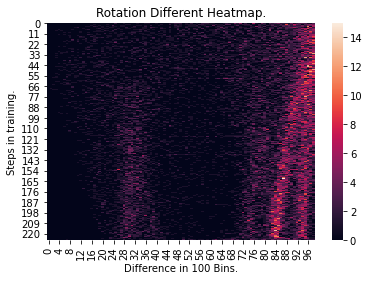

In [7]:
import pandas as pd
import math
import seaborn as sns
from scipy.spatial.transform import Rotation
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter,)
from bokeh.transform import transform
import matplotlib.pyplot as plt

def dotty(p, q):
    return p[0] * q[0] + p[1] * q[1] + p[2] * q[2] + p[3] * q[3]

def qdist(q0, q1):
    q0_minus_q1 = [q0[0] - q1[0], q0[1] - q1[1], q0[2] - q1[2], q0[3] - q1[3]]
    d_minus = math.sqrt(dotty(q0_minus_q1, q0_minus_q1))
    q0_plus_q1 = [q0[0] + q1[0], q0[1] + q1[1], q0[2] + q1[2], q0[3] + q1[3]]
    d_plus = math.sqrt(dotty(q0_plus_q1, q0_plus_q1))
    if d_minus < d_plus:
        return d_minus
    return d_plus

def qrotdiff(q0, q1):
    d = dotty(q0, q1)
    d = math.fabs(d) 
    return 2.0 * math.acos(d)

def vec_to_quat(rv):
    angle = math.sqrt(rv[0] * rv[0] + rv[1] * rv[1] + rv[2] * rv[2])
    ax = rv[0] / angle
    ay = rv[1] / angle
    az = rv[2] / angle

    qx = ax * math.sin(angle/2)
    qy = ay * math.sin(angle/2)
    qz = az * math.sin(angle/2)
    qw = math.cos(angle/2)
    return (qx, qy, qz, qw)


# Convert our data into vectors, then quaternions. Find the difference and create a set of differences
rots_in = R.zrange(D + ":rotations_in_test", 0, -1, withscores=True)
rots_in = [  (i, json.loads(dd)['data']) for (dd, i) in rots_in]
rots_out = R.zrange(D + ":rotations_out_test", 0, -1, withscores=True)
rots_out = [ (i, json.loads(dd)['data']) for (dd, i) in rots_out]
diffs = []
steps = []

for i in range(len(rots_in)):
    step_in = rots_in[i][0]
    step_data_in = rots_in[i][1]
    step_data_out = rots_out[i][1]
    biffs = []
    
    for j in range(len(step_data_in)):
        batch_in = step_data_in[j]
        batch_out = step_data_out[j]
        
        for k in range(len(batch_in)):
          
            rm_in = [batch_in[k][0][0], batch_in[k][1][0], batch_in[k][2][0]]
            rm_out = [batch_out[k][0], batch_out[k][1], batch_out[k][2]]
            diff_rot = qdist(vec_to_quat(rm_in), vec_to_quat(rm_out))
            biffs.append(diff_rot)
    
    diffs.append(biffs)
    steps.append(step_in)

# Take each set of differences and turn them into a histogram
num_classes = 100
bin_size = math.sqrt(2) / num_classes
bins = [i * bin_size for i in range(int(math.sqrt(2)/bin_size))]
hists = []
for diff in diffs:
    hist, edges = np.histogram(diff, bins=bins)
    hists.append(hist)

# Create our heatmap from the histograms with Seaborn and Pandas.
dframe = pd.DataFrame(hists)
ax = sns.heatmap(data=dframe)
ax.set(title="Rotation Different Heatmap.",
      xlabel="Difference in 100 Bins.",
      ylabel="Steps in training.",)

## Evaluation of rotations

If we have input and output evaluation angles, we can compare them to see how consistent the results are.

In [8]:
entropies = []

for diff in diffs:
    hist, edges = np.histogram(diff, bins=bins)
    entropy = scipy.stats.entropy(hist, base=num_classes)
    entropies.append(entropy)
    
p = figure(plot_width=400, plot_height=400, title="Entropy across training.")
p.line([i for i in range(len(entropies))], entropies, line_width=1, line_color='red')
show(p)